In [51]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 5)
        self.hidden_layer2 = nn.Linear(5, 5)
        self.hidden_layer3 = nn.Linear(5, 5)
        self.hidden_layer4 = nn.Linear(5, 5)
        self.hidden_layer5 = nn.Linear(5, 5)
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x, t):
        inputs = torch.cat([x, t], axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output


In [58]:
net = Model_1()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())


In [59]:
def f(x, t, net):
    u = net(x, t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2 * u_t - u
    return pde


In [60]:
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))

In [61]:
u_bc = 6 * np.exp(-3 * x_bc)

In [62]:
x_val = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_val = np.random.uniform(low=0.0, high=1.0, size=(500,1))
u_val = 6 * np.exp(-3 * x_val - 2 * t_val)

In [63]:
pt_x_val = Variable(torch.from_numpy(x_val).float(), requires_grad=False).to(device)
pt_t_val = Variable(torch.from_numpy(t_val).float(), requires_grad=False).to(device)
pt_u_val = Variable(torch.from_numpy(u_val).float(), requires_grad=False).to(device)

In [64]:
training_loss = []
validation_loss = []

In [65]:
iterations = 1000
previous_validation_loss = torch.tensor(float('inf'))
for epoch in range(iterations):
    optimizer.zero_grad()
    
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    loss = mse_u + mse_f
    training_loss.append(float(loss))
    
    
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
        val_pred = net(pt_x_val, pt_t_val)
        val_loss = mse_cost_function(val_pred, pt_u_val)
        validation_loss.append(float(val_loss))
        print(epoch,"Training Loss:", float(loss.data), "Validation Loss:", float(val_loss.data))

0 Training Loss: 2.3287012577056885 Validation Loss: 0.48311084508895874
1 Training Loss: 2.3270676136016846 Validation Loss: 0.48322954773902893
2 Training Loss: 2.3255245685577393 Validation Loss: 0.4833930432796478
3 Training Loss: 2.324077606201172 Validation Loss: 0.4836006164550781
4 Training Loss: 2.322725534439087 Validation Loss: 0.4838513135910034
5 Training Loss: 2.321470260620117 Validation Loss: 0.48414382338523865
6 Training Loss: 2.3203091621398926 Validation Loss: 0.48447638750076294
7 Training Loss: 2.319246292114258 Validation Loss: 0.484846830368042
8 Training Loss: 2.3182811737060547 Validation Loss: 0.4852527976036072
9 Training Loss: 2.317410945892334 Validation Loss: 0.4856913387775421
10 Training Loss: 2.3166327476501465 Validation Loss: 0.4861590564250946
11 Training Loss: 2.3159453868865967 Validation Loss: 0.48665207624435425
12 Training Loss: 2.3153505325317383 Validation Loss: 0.4871661365032196
13 Training Loss: 2.314836263656616 Validation Loss: 0.4876966

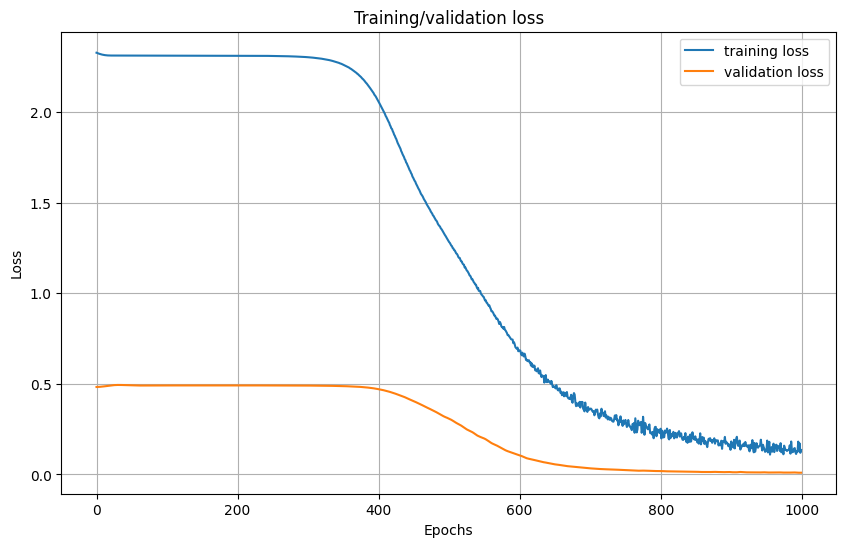

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training/validation loss')
plt.legend()
plt.grid(True)
plt.savefig('curve.svg')
plt.show()

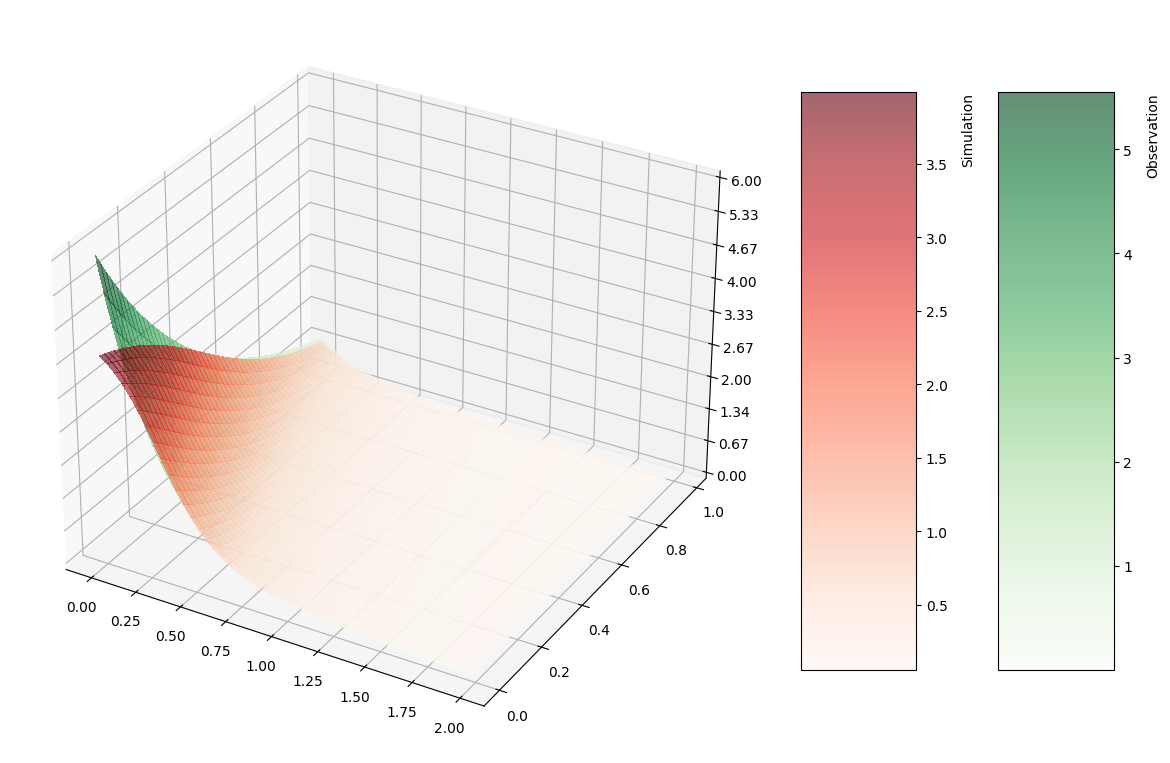

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

x = np.arange(0, 2, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
# Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
u = 6 * np.exp(-3 * x - 2 * t)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

pt_uhat = net(pt_x, pt_t)
uhat = pt_uhat.data.cpu().numpy()
ms_uhat = uhat.reshape(ms_x.shape)
ms_u = u.reshape(ms_x.shape)

surf2 = ax.plot_surface(ms_x, ms_t, ms_uhat, cmap=cm.Reds,
                        linewidth=2, antialiased=False, alpha=0.6, zorder=1)
surf1 = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.Greens,
                        linewidth=2, antialiased=False, alpha=0.6, zorder=2)


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf1, shrink=0.5, aspect=5).set_label(
    'Observation', labelpad=10, loc='top')
fig.colorbar(surf2, shrink=0.5, aspect=5).set_label(
    'Simulation', labelpad=10, loc='top')

plt.savefig('inf.svg')

plt.show()
